# _Python for Scientific Data Analysis_


#  Bayesian Statistics and Markov Chain Monte Carlo methods

## Section 1: An Introduction To The Markov Chain Monte Carlo method and Bayesian Statistics

**caveats**

(caveat: a lot of this is HEAVILY indebted to Daniel Foreman-Mackey and Imad Pasha and in many cases is just plain copied from these sources.  Please browse their work on https://dfm.io/ and https://prappleizer.github.io/.  I also borrowed a bit of text from Charles Greyer (U. Minnesota) )

(caveat #2: your instructor has a heavy frequentist bias by training but likes MCMC largely for its parameter space exploration and clear visualization of correlations between parameters in leading, widely-used code)

### Using MCMC in these notes

For these notes, we will be using the ``emcee`` package for doing MCMC.  Python implementation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) (Goodman and Weare 2010).   It makes up the engine of many MCMC codes used today (e.g. the dynamical code ``orvara``).   

We also want to plot modeling outputs.  MCMC codes give us posterior distributions which then allows us to plot not just these distributions but correlations in the posterior distributions between different parameters in our model.   The widely-used package for this is the logically-named ``corner`` package.  

You can install ``emcee`` and ``corner`` from pip or from conda:

E.g.
```
pip install corner
pip install emcee
```

We will then import these packages along with our standard import calls for doing numerical Python and displaying data:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import corner
import emcee

Before we dive into running MCMC, we need to understand what it is we are actually doing.


### Background

MCMC stands for "Markov-Chain Monte Carlo", and you can use it to fit models to data.  Now, we have covered model fitting before in our SciPy section, where we talked about different optimization algorithms, statistics, and goodness-of-fit.   In many of the optimization algorithms, we had to give the algorithm an initial guess.  We then define formal confidence intervals based on the goodness-of-fit of a model(s) to data.  But ultimately, we had always been approaching model fitting, uncertainties, etc. from a _frequentist_ approach.   This contrasts with the _Bayesian_ approach underlying MCMC.   


As MCMC is a Bayesian method, we then need to first 
back up a step to discuss the differences between these two approaches and what we mean by "Markov Chain" and "Monte Carlo".


Put simply, we are interested in the probability of different model parameters and the two approaches have different views on what "probabilty" means.  To a frequentist, a "probability" is equivalent to (as the name implies) a "frequency" of events occurring.    E.g. a bona fide single 5-$\sigma$ positive detection in a single given experiment will instead be noise $\sim$3$\times$10$^{-7}$ of the time.  For a Bayesian, probability means "certainty", i.e. the strength of a belief.  (A sketch of) [t]he idea originates from Thomas Bayes (and a few others), a Presbyterian minister, philosopher, and statistician who died before seeing his eponymous idea published.   

In the frequentist approach, you do not actually assign a probability to the hypothesis you are testing but in a Bayesian approach you do.  Another key difference is that -- aside from initial "guesses" for parameters -- the frequentist is agnostic about the what the answer _should_ be.   However, a Bayesian considers our _expected_ results given prior evidence.   This may seem like a bit circular logic and not very "objective" (shouldn't we avoid prejudging what nature tells you?).  But it does agree more with how we actually evaluate evidence in practice and the idea that once the data are revealed, then it should result in a shift of our ideas about what the "right" models are.  

Thus, in Bayesian statistics we impose a _**prior**_ probability distribution for a certain set of models being correct.   These priors encode information we as modelers think we already know about the system we are modeling.   For example, if we are doing an MCMC modeling a planet orbiting a star detected with radial-velocity or astrometry, we might set priors on the mass (can't be more massive than the star; more likely to have a lower Msin(i), etc.) and orbit (unlikely to be $>$ 1000 au and more likely to be at a small separation if we can detect with RV, etc.).   This probability is then updated as a _posterior_ probability after the data are evaluated.

So how do we ascribe this "certainty" in Bayesian statistics?  We consider a model where data $x$ are generated from a probability distribution depending on parameter $\theta$.  Our _prior_ knowledge about the parameter $\theta$ is expressed as Pr($\theta$).   We then observe the data and determine "how probable are the observed data given is this parameter $\theta$"?   This is written as $Pr(x|\theta)$.  Finally, we ask "how probable is it to observe these particular data themselves?" 

The "certainty" we have of the parameter given the data is then:


$$Pr(\theta|x) = \frac{Pr(x|\theta)Pr(\theta)}{Pr(x)}$$

Or more crudely ...

$$Pr(model|data) = \frac{Pr(data|model)Pr(model)}{Pr(data)}$$

Or more crudely + roughly ...

$$Pr(model|data) \propto Pr(data|model)Pr(model)$$

_The notes below will describe how we get each of these variables with MCMC._


Great, we understand Bayesian inference.  But what do we mean by "Markov Chain Monte Carlo"?  

Let's start with the last two words: "Monte Carlo".   This is a name for a simulation of probability distributions and calculating probabilities and expectations by averaging over the simulations. At the time the term was invented, the casino at Monte Carlo (in Monaco) was the most famous in the world (Vegas casinos had yet to really take off).  Gambling has something to do with probability (which is news to some people who gamble): hence the name. 

Anyway, a "Monte Carlo" simulation is more useful than just a roll of the (parameter space) dice.  Any integral or sum that cannot be done analytically, either by hand or by a computer algebra system can be put in the form of the expectation of some random variable with respect to some probability distribution. So a Monte Carlo method is a general method of doing integrals or sums over complex parameter spaces.

Now "Markov Chain".  Named after Russian mathematician Andrei Markov, a Markov Chain is a sequence of random variables whose probability at a given time $t+1$ only depends on the variables at time $t$.  

With MCMC, you start with an ensemble of Markov Chains with imposed starting points that provide some sampling of the _prior_ distribution of parameter space.  These chains are stochastic processes of "walkers" which move around randomly according to an algorithm that looks for places with a reasonably high contribution to the integral to move into next, assigning them higher probabilities. 

A lot of the innovation in MCMC focuses in algorithms that tells the code _how_ to move.   The widely-used general framework for MCMC is the "Metropolis-Hastings" algorithm (which we may discuss in Part 2 of this section) and describes the idea of "acceptance ratios" in telling a Markov Chain whether or not to move on to a new value or keep the old one.  It was worked on in part by Edwin Teller (aka father of the hydrogen bomb, aka quasi-villian in "Oppenheimer"), although as in "Oppenheimer" there is some question about truthfulness with Teller's accounts/how much he actually did -- see https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm -- and even more question about whether Metropolis did much at all!

So then a "Markov Chain Monte Carlo" method is a Monte Carlo method that samples/explores an N-dimensional parameter space using Markov Chains.

### How MCMC Works

MCMC is a parameter space exploration tool: a *sampler*.  What do we mean by that? Remember the notes above about "Monte Carlo" methods.  Say your parameter space is super simple and there is some analytical solution to how the the prediction changes as you infinitesimally change a parameter: in the simplest case this could be an integral you can solve by hand.   

But if you have a parameter space that cannot be described by a simple analytical function you need numerical methods to integrate this function.   If the parameter space is N-dimensional (or worse, N-dimensional with covariances between parameters) this gets tougher still.  "Sampling" the parameter space then is basically doing a numerical integration over the range of a highly-complex parameter space.   This is the Monte Carlo-ness of MCMC.

The fundamental process of running an MCMC is to compare generated **models** (our set of $\theta$) against **data** ($x$). Those models are generated by a set of **parameters**, and our goal is usually to find the set of parameters that produces the model that best fits our data.   

We then calculate the probability of our *model* given our *data*. The process goes like this: 

 - Establish a function that outputs a model given a set of input parameters
 
 - Establish an ensemble of walkers defined by a $\theta$ vector that contains a set of parameters as used by the model-generating function. For example, a simple model that the RV-amplitude induced on a star as a function of time due to an orbiting planet is based on the stellar mass $M_{\rm star}$, $Msin(i)$, and $n$ different orbital parameters ($O$) such as the eccentricity, semimajor axis, periastron passage, etc: 
 \begin{equation}\theta_i = \begin{pmatrix} M_{star} \\ Msin(i) \\ O_{0...n-1} \end{pmatrix} \end{equation}
 
  One can imagine a "grid" of possible values for $\theta$, within the prior ranges we've chosen to vary over. 
  
 - And now they're off!  Every walker will now begin exploring the parameter space. To do this, each walker takes a "step" to a new value of $\theta$ (again, $\theta$ is just shorthand for "combination of parameters") and generates a model with that $\theta$. It then compares the model to the given data by some **likelihood function**.
 - The MCMC then checks the ratio of the likelihood generated by the new model with the data vs. the previous model. Generally speaking, if the new location in model phase space produces a better match, the walker moves there and repeats the process. If the new location is worse, it retreats to its previous position and tries a new direction. 
 - Eventually, the walkers all begin climbing towards the regions of highest "likelihood" between the models generated in the data.
 
At the end of the process, we have what is known as a **posterior distribution** or **chain**. Every walker keeps a record of every $\theta$ vector it tried out, and the likelihood of the model given the data at that value of $\theta$. 

Assuming the MCMC runs long enough to *converge* reasonably (that is, the distribution of walkers is not changing *en masse* as a function of step number), the posterior distribution represents a sample of reasonable models to describe our data. 

What do we mean by the "best fit" here? Remember that MCMC is not a "fitter," it is a "sampler." MCMC can't tell us that parameter set $\theta$ is the "best" - one our models will have the numerically highest value of "likelihood" to the data.  But if we reran the MCMC again, or ran it longer, etc., we will get different answers. Every. single. time. What MCMC is better at telling us is something like "if you draw 100 random models out of the posterior distribution, the *spread* in those models is representitive of our ability to constrain the parameters in those models."  I.e. rather than just computing a "best fit" combination of parameters, MCMC lets us figure out a most likely set of parameters and the uncertainties on these parameters.  

To go back to Bayes' theorem, the components of MCMC look like this:

$$Pr(model|data) \propto Pr(data|model)Pr(model)$$
or
$$Posterior Distribution \propto Likelihood Function \times Prior Distribution$$

### A Very Simple (and Contrived) Example: Fitting A Line to Data 

Let's start with a simple and highly contrived situation -- fitting a line to data -- which illustrates how MCMC works (even if you would never actually use MCMC for this situation).

As is clear from the previous section, we are going to need functions 1) that generate models with a specific set of parameters $\theta$, 2) that give a prior probability distribution for $\theta$, and 3) that compute a likelihood function describing the agreement.   We feed these three ingredients into an MCMC sampler to then generate posterior distributions.

We're going to consider a linear model where the quoted
uncertainties are underestimated by a constant fractional amount.
You can generate a synthetic dataset from this model:

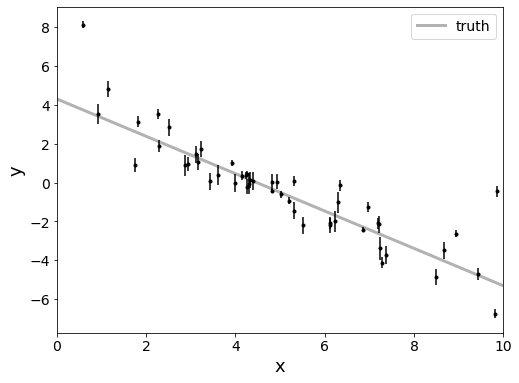

In [42]:
#plt.figure(figsize=(8,6))
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

fig,ax=plt.subplots(figsize=(8,6))

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label="truth")
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x",fontsize=18)
ax.set_ylabel("y",fontsize=18)
ax.legend(loc='best',fontsize=14);

The true model is shown as the thick grey line and the effect of the
underestimated uncertainties is obvious when you look at this figure.
The standard way to fit a line to these data (assuming independent Gaussian
error bars) is linear least squares.
Linear least squares is appealing because solving for the parameters—and
their associated uncertainties—is simply a linear algebraic operation.
Following the notation in [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), the linear least squares solution to these
data is

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


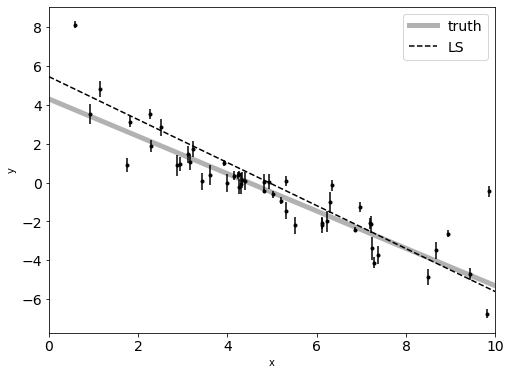

In [43]:
A = np.vander(x, 2) 
#note: this is a Vandermonde matrix: prints out x as the first column and "1" as each entry in the second.
# Think of it as "what a least-squares minimization with errors does "under the hood"
# see the notes from Hogg et al. (2010)

#print(x)
#print(A)

C = np.diag(yerr * yerr) 
#assuming that the data point measurements are independent; 
#otherwise the off-diagonal terms would be non-zero

ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

fig,ax=plt.subplots(figsize=(8,6))
ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=5, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
ax.legend(fontsize=14)
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x")
ax.set_ylabel("y");

(Note: this analytical solution may seem to come out of nowhere but see Equations 2--6 in Hogg et al. 2010).

This figure shows the least-squares estimate of the line parameters as a dashed line.
This isn't an unreasonable result but the uncertainties on the slope and
intercept seem a little small (because of the small error bars on most of the
data points).

## Setting up MCMC 


As mentioned above, to do an MCMC you need several key ingredients:

* A **model function**
* A **likelihood function** of that model being correct
* A **prior probability distribution** on the model parameters
* A good **sampler** to explore explore the model phase space, compare with the data, and derive posterior distributions for parameters.   This is where the first MC (Markov Chain) and second MC (Monte Carlo) in the MCMC name come into play.

Let's go through these in detail ...

#### Model Function

In this particular case, the nominal model function is very simple: 

``y = mx+b``, 

where we have measurment errors of $\sigma$.  However, it is clear in the example that our nominal error bars are underestimated.  So we model their underestimation as a constant parameter ``f``.

#### Likelihood Function
We now need a function to describe the likelihood of a particular model.   This function takes as an argument theta as well as the $x$, $y$, and $y_{err}$ of your actual theta. It's job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points. 

Now, we encountered something like this before with our (frequentist) statistics section (SciPy, part 3): i.e. $\chi^{2}$ statistic for data drawn from a normal distribution:

$f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-0.5((x-\mu)/\sigma)^{2}}$.  

The probability density function for $f(x)$ tells us the likelihood of an individual data point given a model distribution (i.e. for a mean value $\mu$ and standard deviation $\sigma$).

To test if a set of data is likely for a particular model, we would determine the likelihood of each data point, and
multiply each of these individual likelihoods to determine an overall likelihood. The most probable model would maximize this likelihood:


$$\mathcal{L}(y|x,\sigma, m, b,f)= \prod_{i = 1}^{n}  (y|x,\sigma, m, b,f) = (\frac{1}{{2\pi\sigma_n^{2}}})^{n/2}e^{-0.5(\sum_{i = 1}^{n}(y_{i}-(mx_{i}+b))^{2})/\sigma_n^{2})}$$

(note: $\prod_{i = 1}^{n}$ is a product operator (i.e. _multiply_ each term in the summation together.  This is _similar_ in concept to the basic idea with a $\chi^{2}$ test where you try to minimize the _sum_ of each of exponents in the PDF).

The exponential is messy, so often one describes in terms of the "log-likelihood" which basically means taking the logarithm of both sides of the equation:

$$ln(\mathcal{L}(y|x,\sigma, m, b,f))= -\frac{1}{2} (\sum_{i = 1}^{n}{\left(\frac{y_{i}-(mx_{i}+b)}{\sigma_n}\right)^{2} + ln(2\pi\,\sigma_n^2)) }$$

Now, the least squares solution found in the previous section is the maximum
likelihood result for a model where the error bars are assumed correct,
Gaussian and independent. From just looking at the fit, we can probably guess that the error bars have been slightly underestimated. So we are going to model that by inflating the model errors by a constant $f$ value.

Therefore, $\sigma$ in the above equation is ... 
$$
    \sigma_n^2 = \sigma_{n,o}^2+f^2\,(m\,x_n+b)^2 \quad ,
$$

Where $\sigma_{n,o}$ are our original errors and $\sigma_n$ are the inflated errors (inflated by some constant factor of the data value).

We can then write this log-likelihood function as:

In [40]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

We gain some insight if we consider only this function (i.e. if we just try to solve for the linear fit using this function) ...

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


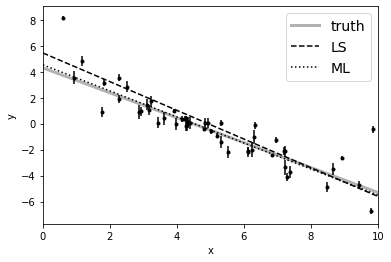

In [45]:
#a demo of maximum likelihood 
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This is _a lot_ closer to the ground-truth value**.   Now, how do we estimate the uncertainties on m and b? What's more, we probably don't really care too much about the value of f but it seems worthwhile to propagate any uncertainties about its value to our final estimates of m and b. This is where MCMC comes in.  

So we proceed with the other ingredients of MCMC: the prior probability and the MCMC sampler.


** Note: Scipy.optimize _minimizes_ functions whereas we would like to _maximize_ the likelihood. This goal is equivalent to minimizing the negative likelihood (or in this case, the negative log likelihood). 


#### Prior Probability

The _prior probability_ function encodes any previous knowledge that we have about the parameters: results from other experiments, physically acceptable ranges, etc.  Priors are essential for doing MCMC: all that MCMC does is draw samples from a probability distribution and you want that to be a probability distribution for your parameters.

So what should be our prior?  We can make the shape of the prior probability distribution be anything we want (its mean, standard deviation, whether it is normally distributed, log-normal, flat, etc.). But it should be reasonably motivated.  

In this example, we'll use uniform (so-called "uninformative") priors on $m$, $b$, and $ln(f)$. For example, we'll use the following conservative prior on $m$:

$$
p(m) = \left \{\begin{array}{ll}
        1 / 6 \,, & \mbox{if}\,-5 < m < 1 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .
$$

In [98]:
def log_prior(theta):
    m, b, log_f = theta
   # if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
    if -5.0 < m < 1.0 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Then, combining this with the definition of ``log_likelihood`` from above, the full
log-probability function is:

In [99]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

#### Putting It All Together

After all this setup, now we need a MCMC sampler.  We will use ``emcee`` to perform MCMC.  
We'll start by initializing the walkers in a phase space region centered around the
maximum likelihood result and then run 5,000 steps of MCMC.



In [100]:
#start with ML result (soln.x) + some random number centered on the ML value.  
pos = soln.x + 1e-4 * np.random.randn(32, 3)
pos[:,0]
print("starting positions for m, b, and log(f) are \n {0}, {1}, {2}".format(pos[:,0],pos[:,1],pos[:,2]))


starting positions for m, b, and log(f) are 
 [-1.00291298 -1.0030735  -1.00309294 -1.00301132 -1.00310509 -1.00286024
 -1.00298488 -1.00307018 -1.00305494 -1.00304386 -1.00305897 -1.00304099
 -1.00302315 -1.00286284 -1.00295463 -1.003044   -1.00291429 -1.00310272
 -1.00305339 -1.00319656 -1.0033472  -1.00298291 -1.0029722  -1.00282029
 -1.00281576 -1.00311221 -1.00298552 -1.00291177 -1.00300824 -1.00314306
 -1.00305077 -1.00304516], [4.52848121 4.52832768 4.52825608 4.52829227 4.52839548 4.52826618
 4.52825722 4.52827667 4.52833967 4.52821047 4.52813945 4.52854433
 4.52822184 4.52834547 4.52830943 4.52827646 4.52827746 4.52835969
 4.52824335 4.5283636  4.5283937  4.52828196 4.52832746 4.52831528
 4.52813645 4.52830947 4.5284197  4.52825819 4.5283569  4.52838249
 4.52830883 4.52818627], [-0.79019689 -0.79030365 -0.79049914 -0.79049971 -0.79030655 -0.79035496
 -0.79036691 -0.790578   -0.79028344 -0.7902906  -0.79042702 -0.7903928
 -0.79040732 -0.79052507 -0.79039547 -0.79048211 -0.79048

As you can see, the starting positions for parameters for the 32 walkers are all clustered around the ML value.

Now, let's run MCMC...

In [101]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True); #this should take about 10-30s on your computer

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 511.90it/s]


Let's take a look at what the sampler has done.
A good first step is to look at the time series of the parameters in
the chain.
The samples can be accessed using the {func}`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(5000, 32, 3)` giving the parameter values for each walker
at each step in the chain.
The figure below shows the positions of each walker as a function of the
number of steps in the chain:

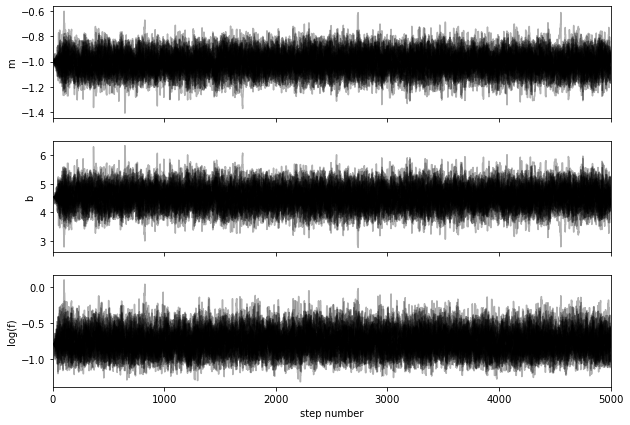

In [102]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.set_xlabel("step number");
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the
maximum likelihood values and then they quickly wander and start exploring the
full posterior distribution.
In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in".
That is a hard statement to make quantitatively, but we can look at an estimate
of the integrated autocorrelation time (see the {ref}`autocorr` tutorial for more details):

In [103]:
tau = sampler.get_autocorr_time()
print(tau)

[36.44410169 35.38550922 37.30309458]


This suggests that only about 40 steps are needed for the chain to "forget" where it started.
It's not unreasonable to throw away a few times this number of steps as "burn-in".
Let's discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain (i.e. instead of a dimension of 32x3 we have 96,1 so that we have a flat list of samples:

In [104]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
#flat_samples = sampler.get_chain(discard=100, thin=15) flat_sample.shape = (326,32,3)
print(flat_samples.shape) 

(10432, 3)


### Results

Now that we have this list of samples, let's make one of the most useful plots
you can make with your MCMC results: *a corner plot*.
You'll need the [corner.py module](http://corner.readthedocs.io) but
once you have it, generating a corner plot is as simple as:

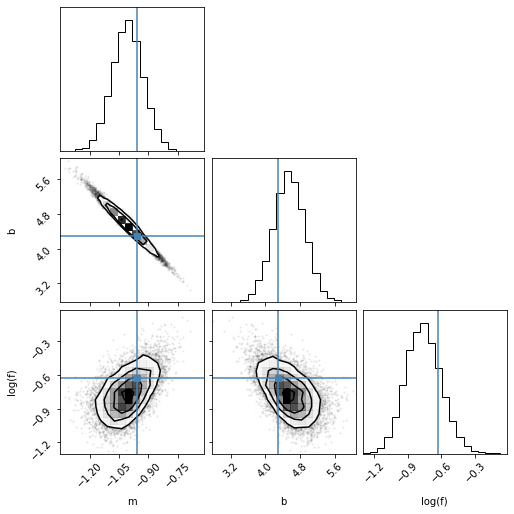

In [105]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

You can add more information: e.g. plotting the quantiles (50%, and 68% confidence interval) as follows ...
    

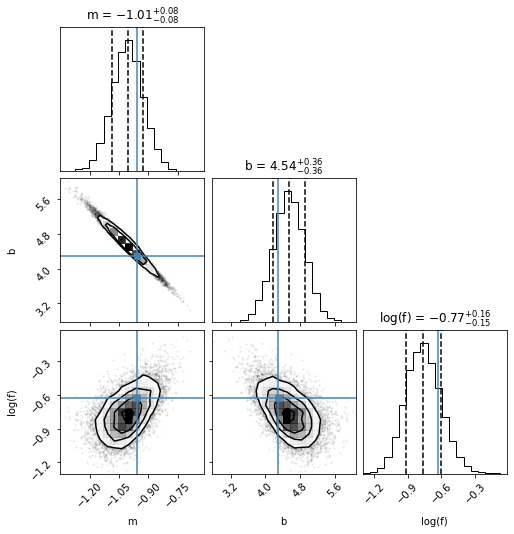

In [106]:
fig = corner.corner(flat_samples,show_titles=True,truths=[m_true, b_true, np.log(f_true)],
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

To more significant figures, the 50% quantile (and 68% CI) values are ...

In [91]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The corner plot shows all the one and two dimensional projections of the
posterior probability distributions of your parameters.
This is useful because it quickly demonstrates all of the covariances between
parameters.
Also, the way that you find the marginalized distribution for a parameter or
set of parameters using the results of the MCMC chain is to project the
samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each
parameter independently in the histograms along the diagonal and then the
marginalized two dimensional distributions in the other panels.

Now we can project our results into the space of
the observed data.
To do this, you can choose a few (say 100 in this case) samples from the chain
and plot them on top of the data points:

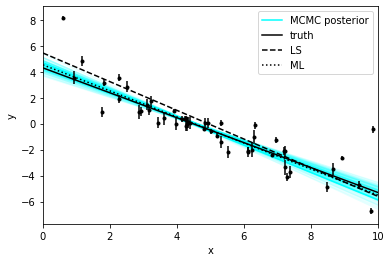

In [107]:
inds = np.random.randint(len(flat_samples), size=100)

sample0=flat_samples[0]
plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), color='cyan', alpha=1,label='MCMC posterior')
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), color='cyan', alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best');

As you can see, the simple LS solution is way off for small values of x.   And MCMC gives us a better idea of the certainty around the best-fit model (which is close to the ML solution).

And there you have it: a simple demonstration of MCMC with the ``emcee`` package.

In the next section (time permitting), we will go through a more complex example.   And if time is _really_ permitting, we will have a homework problem focused on a simple MCMC simulation.